<a href="https://colab.research.google.com/github/bhadreshpsavani/TimeSerierAnalysisOnCoalConsumption/blob/main/CoalConsumptionAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis of Britans Power Consumption:

We are having dataset of power consumtion demand and the sources of energy **we want to forcast requirement of coal consumption**

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('https://query.data.world/s/pija6a4rfvhbwhsmxgs6waee6tqgkg', parse_dates=[1], index_col=1)

In [3]:
df.head()

,id,demand,frequency,coal,nuclear,ccgt,wind,pumped,hydro,biomass,solar
timestamp,,,,,,,,,,,
2012-01-01 00:00:01,62694,30590,50.126999,8693,7121,8568,2740,0,728,0,0.0
2012-01-01 00:05:06,62695,30490,50.039001,8650,7120,8441,2812,0,732,0,0.0
2012-01-01 00:10:01,62696,30802,50.000000,8880,7125,8427,2896,0,744,0,0.0
2012-01-01 00:15:01,62697,31180,50.028999,9111,7122,8494,2964,0,748,0,0.0
2012-01-01 00:20:01,62698,31241,50.002998,9195,7114,8449,2992,0,750,0,0.0


In [4]:
# drop unnecessary column
df.drop(columns=['id'],inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 796453 entries, 2012-01-01 00:00:01 to 2019-08-03 20:10:34
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0    demand     796453 non-null  int64  
 1    frequency  796453 non-null  float64
 2    coal       796453 non-null  int64  
 3    nuclear    796453 non-null  int64  
 4    ccgt       796453 non-null  int64  
 5    wind       796453 non-null  int64  
 6    pumped     796453 non-null  int64  
 7    hydro      796453 non-null  int64  
 8    biomass    796453 non-null  int64  
 9    solar      796453 non-null  float64
dtypes: float64(2), int64(8)
memory usage: 66.8 MB


We are having 796453 records in our data

In [6]:
df.describe()

,demand,frequency,coal,nuclear,ccgt,wind,pumped,hydro,biomass,solar
count,796453.000000,796453.000000,796453.000000,796453.000000,796453.000000,796453.000000,796453.000000,796453.000000,796453.000000,7.964530e+05
mean,33441.390026,49.949458,7533.566650,7214.377451,11540.665320,2905.132293,303.329773,400.898907,1186.621983,4.413354e+02
std,7238.845210,1.609492,6410.003369,934.940076,5166.125208,2233.491732,328.883426,255.525493,745.151475,2.587864e+03
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,27874.000000,49.959999,1226.000000,6684.000000,7361.000000,1142.000000,0.000000,189.000000,679.000000,0.000000e+00
50%,32737.000000,49.997002,6420.000000,7337.000000,11352.000000,2353.000000,290.000000,362.000000,1116.000000,0.000000e+00
75%,38495.000000,50.042000,13070.000000,7888.000000,15167.000000,4162.000000,437.000000,575.000000,1918.000000,0.000000e+00
max,254852.000000,50.403000,25239.000000,9346.000000,27150.000000,12456.000000,2861.000000,1434.000000,3093.000000,1.420000e+06


From above data we can say that coal and CCGT is contributing maximum in the Energy generation

In [7]:
# remove space from column name
df.columns = [item.strip() for item in list(df.columns)]

In [8]:
df['energy_produced'] = df[['coal', 'nuclear', 'ccgt', 'wind', 'pumped', 'hydro', 'biomass', 'solar']].sum(axis=1)
df['energy_produced'].head(10)

 timestamp
2012-01-01 00:00:01    27850.0
2012-01-01 00:05:06    27755.0
2012-01-01 00:10:01    28072.0
2012-01-01 00:15:01    28439.0
2012-01-01 00:20:01    28500.0
2012-01-01 00:25:10    28600.0
2012-01-01 00:30:01    28515.0
2012-01-01 00:35:05    28314.0
2012-01-01 00:40:14    28424.0
2012-01-01 00:45:01    28491.0
Name: energy_produced, dtype: float64

In [9]:
df['demand'].head(10)

 timestamp
2012-01-01 00:00:01    30590
2012-01-01 00:05:06    30490
2012-01-01 00:10:01    30802
2012-01-01 00:15:01    31180
2012-01-01 00:20:01    31241
2012-01-01 00:25:10    31340
2012-01-01 00:30:01    31255
2012-01-01 00:35:05    31054
2012-01-01 00:40:14    31166
2012-01-01 00:45:01    31232
Name: demand, dtype: int64

In [10]:
df[['demand', 'energy_produced','coal', 'nuclear', 'ccgt', 'wind', 'pumped', 'hydro', 'biomass', 'solar']].corr()

,demand,energy_produced,coal,nuclear,ccgt,wind,pumped,hydro,biomass,solar
demand,1.000000,0.927885,0.605359,0.116944,0.592903,-0.006657,0.608702,0.508998,-0.112955,-0.053173
energy_produced,0.927885,1.000000,0.552917,0.112190,0.594134,0.005152,0.570889,0.457708,-0.083840,0.281898
coal,0.605359,0.552917,1.000000,0.175369,-0.162401,-0.306513,0.218759,0.207870,-0.649068,-0.167465
nuclear,0.116944,0.112190,0.175369,1.000000,-0.096811,-0.179884,0.059662,0.017442,-0.218199,-0.059732
ccgt,0.592903,0.594134,-0.162401,-0.096811,1.000000,-0.092967,0.500891,0.237871,0.369254,0.095912
wind,-0.006657,0.005152,-0.306513,-0.179884,-0.092967,1.000000,-0.033267,0.256919,0.300231,0.054473
pumped,0.608702,0.570889,0.218759,0.059662,0.500891,-0.033267,1.000000,0.441208,-0.012562,-0.002637
hydro,0.508998,0.457708,0.207870,0.017442,0.237871,0.256919,0.441208,1.000000,0.109851,-0.042044
biomass,-0.112955,-0.083840,-0.649068,-0.218199,0.369254,0.300231,-0.012562,0.109851,1.000000,0.143576
solar,-0.053173,0.281898,-0.167465,-0.059732,0.095912,0.054473,-0.002637,-0.042044,0.143576,1.000000


### Observations:
From above analysis of correlation between columns we can say that,
* The Demand and total Produced Energy are highly correlated 
* Smiliarly there is 0.6 correlation between Demand and Coal Production 

### 1. Resampling:

In [108]:
data = df.resample('1H').sum()
data.head()

,demand,frequency,coal,nuclear,ccgt,wind,pumped,hydro,biomass,solar,energy_produced
timestamp,,,,,,,,,,,
2012-01-01 00:00:00,372778,600.332000,107545,84685,101670,35915,1120,8971,0,0.0,339906.0
2012-01-01 01:00:00,365904,600.249000,103154,83313,101089,35674,689,9108,0,0.0,333027.0
2012-01-01 02:00:00,352149,600.361998,92415,83339,99320,35211,0,8977,0,0.0,319262.0
2012-01-01 03:00:00,330551,599.778998,74389,83337,95330,35654,0,8952,0,0.0,297662.0
2012-01-01 04:00:00,318290,599.612998,64333,84255,91842,36024,0,8940,0,0.0,285394.0


In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66525 entries, 2012-01-01 00:00:00 to 2019-08-03 20:00:00
Freq: H
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   demand           66525 non-null  int64  
 1   frequency        66525 non-null  float64
 2   coal             66525 non-null  int64  
 3   nuclear          66525 non-null  int64  
 4   ccgt             66525 non-null  int64  
 5   wind             66525 non-null  int64  
 6   pumped           66525 non-null  int64  
 7   hydro            66525 non-null  int64  
 8   biomass          66525 non-null  int64  
 9   solar            66525 non-null  float64
 10  energy_produced  66525 non-null  float64
dtypes: float64(3), int64(8)
memory usage: 6.1 MB


### 2. Analysis

#### Rolling Mean:

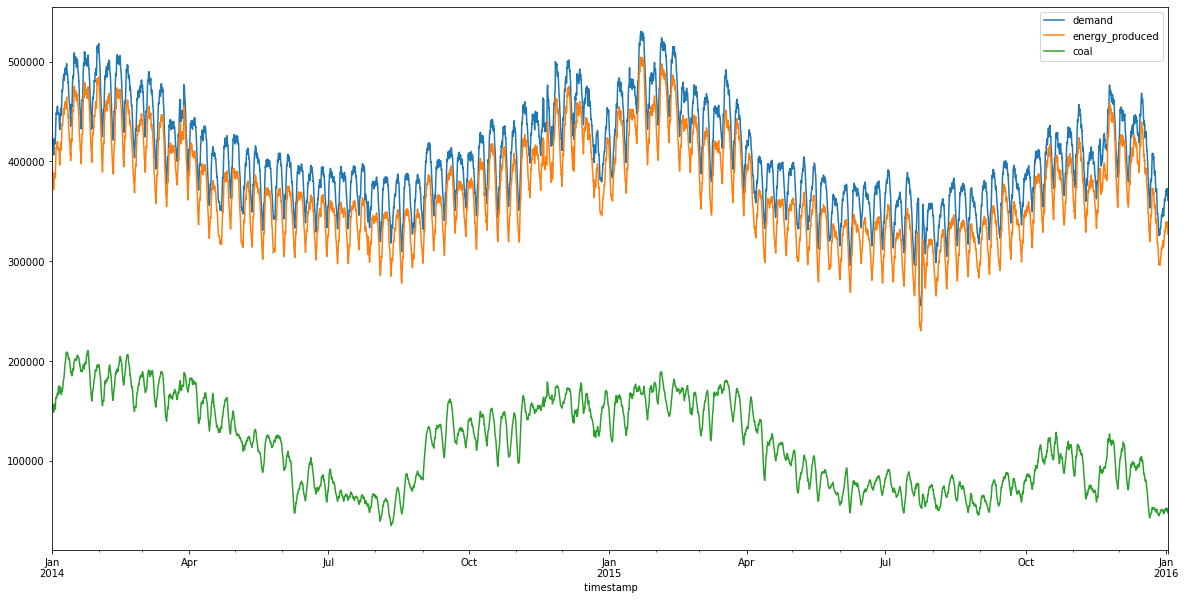

In [110]:
data[['demand', 'energy_produced', 'coal']].rolling(50).mean()['2014-01-01':'2016-01-01'].plot(figsize=(20, 10))


#### 2. Trends and Seasonality

In [112]:
data = data.drop(columns=['energy_produced'])

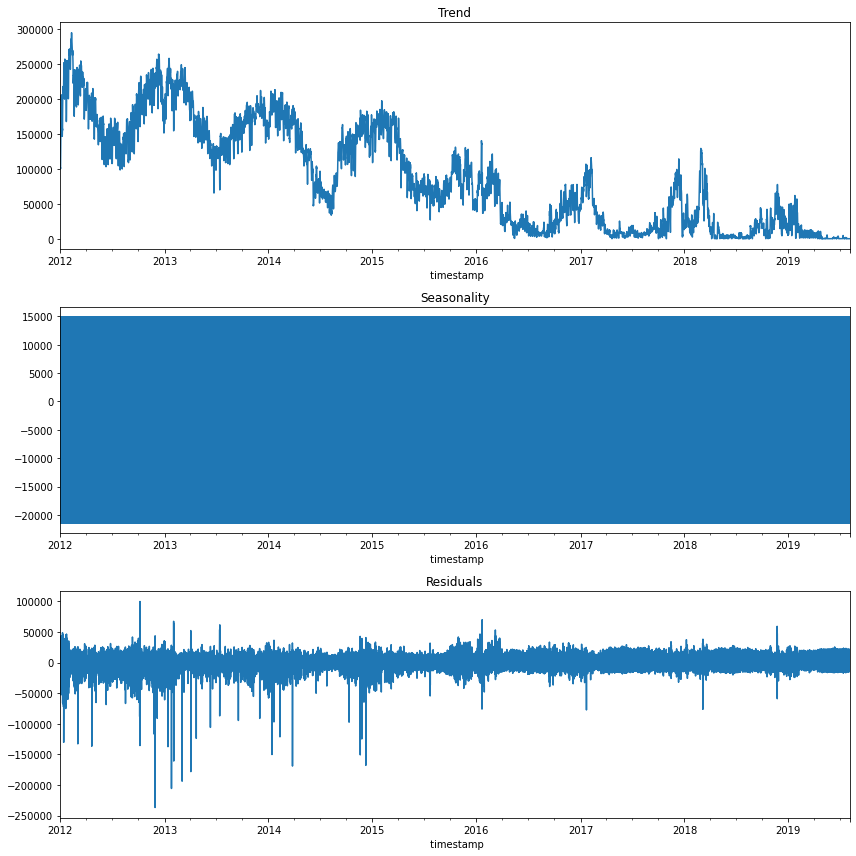

In [116]:
decomposed = seasonal_decompose(data['coal'])
plt.figure(figsize=(12, 12))
plt.subplot(311)
# axes ax equal to plt.gca() (gca = get current axis)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

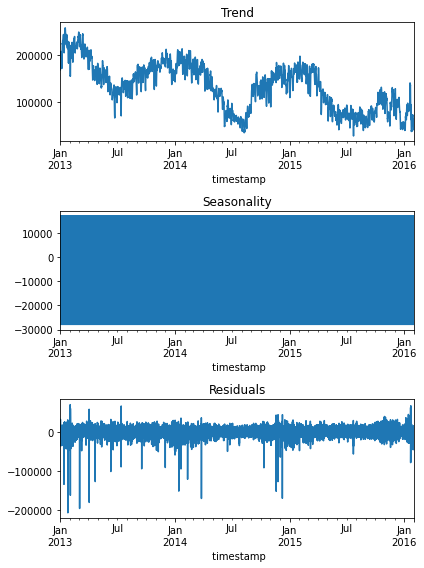

In [117]:

decomposed = seasonal_decompose(data['2013-01':'2016-01']['coal'])
plt.figure(figsize=(6, 8))
plt.subplot(311)
# axes ax equal to plt.gca() (gca = get current axis)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

From above graph we can say that trend is decaresing over time

### 3. Stationary Series:

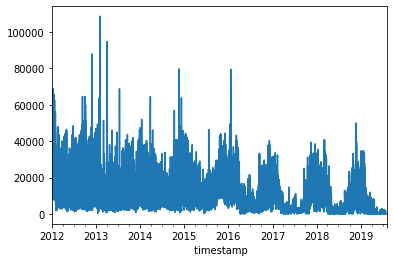

In [118]:
data['coal'].rolling(15).std().plot()

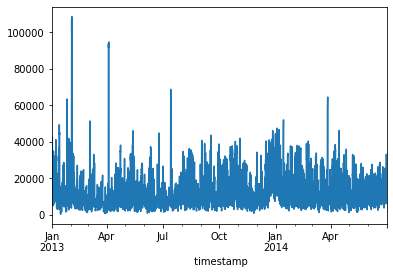

In [119]:
data['coal'].rolling(15).std()['2013-01':'2014-06'].plot()

The distribution does change, so the stochastic process is nonstationary

## Feature Extraction:

Now we will train a machine learning model which will take time as input and predict coal production.

In [120]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['coal'].shift(lag)
    data['rolling_mean'] = data['coal'].shift().rolling(rolling_mean_size).mean()

In [141]:
make_features(data, 31, 12)

In [142]:
data.head()

,demand,frequency,coal,nuclear,ccgt,wind,pumped,hydro,biomass,solar,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-01 12:00:00,419175,599.595998,130429,85256,122909,32771,5746,9186,0,0.0,2012,1,1,6,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 13:00:00,429637,599.546006,133890,85251,127497,31716,9290,9119,0,0.0,2012,1,1,6,13,130429.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 14:00:00,432110,599.741001,133255,85280,133527,28228,9890,9055,0,0.0,2012,1,1,6,14,133890.0,130429.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 15:00:00,437761,600.098004,136129,85329,141879,27810,4582,9154,0,0.0,2012,1,1,6,15,133255.0,133890.0,130429.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 16:00:00,462535,600.976007,141926,85375,155832,27950,7381,11191,0,0.0,2012,1,1,6,16,136129.0,133255.0,133890.0,130429.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
print("Before",len(data))
data = data.dropna()
print("After",len(data))

Before 66513
After 66482


In [144]:
features = data.drop(columns=['coal'])
target = data['coal']

In [145]:
full_train_X, test_X, full_train_y, test_y = train_test_split(features, target, shuffle=False, test_size=0.10)
train_X, valid_X, train_y, valid_y = train_test_split(full_train_X, full_train_y, shuffle=False, test_size=0.15)
print("Trainset Size", len(train_X), "Validation set Size", len(valid_X), "Test Size", len(test_X))

Trainset Size 50858 Validation set Size 8975 Test Size 6649


### Create Baseline Model

In [146]:
# using mean
pred_base = np.ones(test_y.shape)*full_train_y.mean()
np.sqrt(mean_squared_error(pred_base, test_y))

88501.82433361834

In [147]:
# lets check how much error we are getting if we consider previous value as our  prediction
pred_previous = test_y.shift()
pred_previous.iloc[0]=full_train_y.iloc[-1]
np.sqrt(mean_squared_error(pred_previous, test_y))

4660.477698390969

previous value is giving better result so we will use this as our baseline score

In [148]:
def rmse(pred_valid, valid_y):
    return np.sqrt(mean_squared_error(pred_valid, valid_y))

## Model Selection:

#### LinearRegression:

In [149]:
lr = LinearRegression()

In [150]:
lr.fit(train_X, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [151]:
pred_valid = lr.predict(valid_X)
rmse(pred_valid, valid_y)

4130.41900120057

#### Gradient Boosting Regression:

In [152]:
%%time
gb_regressor = GradientBoostingRegressor(random_state=12345, n_estimators=200, max_depth=5)
gb_regressor.fit(train_X, train_y)

CPU times: user 5min, sys: 82.5 ms, total: 5min
Wall time: 5min 3s


In [153]:
pred_valid = gb_regressor.predict(valid_X)
rmse(pred_valid, valid_y)

3638.9307151944377

## Model Training:

In [154]:
%%time
gb_regressor = GradientBoostingRegressor(random_state=12345, n_estimators=200, max_depth=5)
gb_regressor.fit(full_train_X, full_train_y)

CPU times: user 5min 59s, sys: 82.9 ms, total: 5min 59s
Wall time: 6min 3s


In [155]:
pred_test = gb_regressor.predict(test_X)
rmse(pred_test, test_y)

3246.1373905682144